In [1]:
import findspark
findspark.init()

In [2]:
import os
# Make sure setup is correct
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))

SPARK_HOME: C:\spark\spark-4.0.0-bin-hadoop3


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, split, to_timestamp, udf, from_unixtime
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Ensure PySpark uses Anaconda Python
os.environ["PYSPARK_PYTHON"] = r"C:\Users\SW\anaconda\envs\spark_py311\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\SW\anaconda\envs\spark_py311\python.exe"

# Step 1: Start Spark Session
spark = SparkSession.builder \
    .appName("DataTransform") \
    .getOrCreate()

In [4]:
import os, platform

print("🧠 Kernel Python:", platform.python_version())
print("🔗 PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))
print("🔗 PYSPARK_DRIVER_PYTHON:", os.environ.get("PYSPARK_DRIVER_PYTHON"))


🧠 Kernel Python: 3.11.13
🔗 PYSPARK_PYTHON: C:\Users\SW\anaconda\envs\spark_py311\python.exe
🔗 PYSPARK_DRIVER_PYTHON: C:\Users\SW\anaconda\envs\spark_py311\python.exe


## Data Ingestion

In [5]:
# Reading the raw data
raw_df = spark.read.text("cc_sample_transaction.json")
raw_df.head(2)

[Row(value='{"Unnamed: 0":"0","trans_date_trans_time":"2019-01-01 00:00:18","cc_bic":"CITIUS33CHI","cc_num":"2703186189652095","merchant":"fraud_Rippin, Kub and Mann","category":"misc_net","amt":"4.97","personal_detail":"{\\"person_name\\":\\"Jennifer,Banks,eeeee\\",\\"gender\\":\\"F\\",\\"address\\":\\"{\\\\\\"street\\\\\\":\\\\\\"561 Perry Cove\\\\\\",\\\\\\"city\\\\\\":\\\\\\"Moravian Falls\\\\\\",\\\\\\"state\\\\\\":\\\\\\"NC\\\\\\",\\\\\\"zip\\\\\\":\\\\\\"28654\\\\\\"}\\",\\"lat\\":\\"36.0788\\",\\"long\\":\\"-81.1781\\",\\"city_pop\\":\\"3495\\",\\"job\\":\\"Psychologist, counselling\\",\\"dob\\":\\"1988-03-09\\"}","trans_num":"0b242abb623afc578575680df30655b9","merch_lat":"36.011293","merch_long":"-82.048315","is_fraud":"0","merch_zipcode":"28705","merch_eff_time":"1325376018798532","merch_last_update_time":"1325376018666"}'),
 Row(value='{"Unnamed: 0":"1","trans_date_trans_time":"2019-01-01 00:00:44","cc_bic":"ADMDUS41","cc_num":"630423337322","merchant":"fraud_Heller, Gutmann

In [6]:
#Check the row count of raw data, and after all transformation, check the row count again to make sure everything is alright.
raw_df.count()

1296675

In [7]:
## use this 
from pyspark.sql import Row
# quickly inspect its schema and exploring nested structures
sample_json = raw_df.select("value").first()["value"]
rdd = spark.sparkContext.parallelize([sample_json])
df = spark.read.json(rdd)

df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, split, to_timestamp,from_utc_timestamp, from_unixtime, date_format, udf, expr, lit
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Step 1: Start Spark Session
spark = SparkSession.builder \
    .appName("FraudDataTransform") \
    .getOrCreate()

# Step 2: Read raw data line by line (each is a JSON string)
raw_df = spark.read.text("cc_sample_transaction.json")  # 🔁 Replace path

# Step 3: Infer schema from sample row
sample_json = raw_df.select("value").first()["value"]
json_schema = spark.read.json(spark.sparkContext.parallelize([sample_json])).schema

# Step 4: Parse JSON into columns
df = raw_df.select(from_json(col("value"), json_schema).alias("data")).select("data.*")

# Step 5: Define nested schemas
personal_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])

# Step 6: Parse personal_detail and address
df = df.withColumn("personal_json", from_json("personal_detail", personal_schema))
df = df.withColumn("address_json", from_json("personal_json.address", address_schema))

import re
# removing any titles in front of first name
titles = {"Dr.", "Mr.", "Mrs.", "Ms.", "Sir", "Madam", "Prof."}

@udf(StringType())
def extract_first(name):
    try:
        # Step 0: Force string & trim early
        if name is None:
            return None
        name = str(name).strip()

        if not name:
            return None

        # Step 1: Normalize delimiters
        clean = re.sub(r"[@/|]", ",", name)

        # Step 2: Split by commas, strip whitespace
        parts = [p.strip() for p in clean.split(",") if p.strip()]

        # Step 3: Remove known titles
        if parts and parts[0] in titles:
            parts = parts[1:]

        # Step 4: Take first available part
        first = parts[0] if parts else None

        if first:
            # Step 5: Remove non-letters
            first = re.sub(r"[^A-Za-z\s]", "", first).strip()

            # Step 6: Keep only the first word if there's a space
            first = first.split(" ")[0]

        return first if first else None

    except Exception as e:
        return None

@udf(StringType())
def extract_last(name):
    try:
        if not name:
            return None

        name = str(name).strip()
        clean = re.sub(r"[@/|]", ",", name)

        parts = [p.strip() for p in clean.split(",") if p.strip()]

        if parts and parts[0] in titles:
            parts = parts[1:]

        last = None
        if len(parts) > 1:
            last = parts[1].split(" ")[0]  # Grab before space if compound

        if last:
            last = re.sub(r"[^A-Za-z]", "", last).strip()
            return last if last else None

        return None

    except:
        return None


from pyspark.sql.functions import expr, lpad, concat_ws, from_unixtime, floor, col


# Step 8: Build transformed DataFrame
df_clean = df.withColumn("first", extract_first(col("personal_json.person_name"))) \
    .withColumn("last", extract_last(col("personal_json.person_name"))) \
    .withColumn("gender", col("personal_json.gender")) \
    .withColumn("street", col("address_json.street")) \
    .withColumn("city", col("address_json.city")) \
    .withColumn("state", col("address_json.state")) \
    .withColumn("zip", col("address_json.zip")) \
    .withColumn("lat", col("personal_json.lat").cast(DoubleType())) \
    .withColumn("long", col("personal_json.long").cast(DoubleType())) \
    .withColumn("city_pop", col("personal_json.city_pop").cast(IntegerType())) \
    .withColumn("job", col("personal_json.job")) \
    .withColumn("dob", col("personal_json.dob")) 
    #.withColumn("trans_date_trans_time", to_timestamp("trans_date_trans_time"))
    #.withColumn("merch_eff_time", from_unixtime((col("merch_eff_time") / 1_000_000).cast("long"))) \
    #.withColumn("merch_last_update_time", from_unixtime((col("merch_last_update_time")/1000).cast("long")))

# Make sure time is in the right format.

df_clean = df_clean \
    .withColumn(
        "merch_eff_time",
        concat_ws(
            '',
            from_unixtime(floor(col("merch_eff_time") / 1000000)),
            lit('.'),
            lpad((col("merch_eff_time") % 1000000).cast("string"), 6, '0'),
            lit(' +08:00')
        )
    ) \
    .withColumn(
        "merch_last_update_time",
        concat_ws(
            '',
            from_unixtime(floor(col("merch_last_update_time") / 1000)),
            lit('.'),
            lpad((col("merch_last_update_time") % 1000).cast("string"), 3, '0'),
            lit('000 +08:00')
        )
    ).withColumn(
    "trans_date_trans_time",
    date_format(
        from_utc_timestamp(
            to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss"),
            "Asia/Kuala_Lumpur"
        ),
        "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
    )
)



# Step 9: Select final clean columns
final_df = df_clean.select(
    "Unnamed: 0", "trans_date_trans_time", "cc_num", "merchant", "category", "amt",
    "first", "last", "gender", "street", "city", "state", "zip", "lat", "long",
    "city_pop", "job", "dob", "trans_num", "merch_lat", "merch_long", "is_fraud",
    "merch_zipcode", "merch_eff_time", "merch_last_update_time", "cc_bic"
)

# Show result
final_df.show(truncate=False)
final_df.printSchema()


#to_timestamp("personal_json.dob", "yyyy-MM-dd")) \

+----------+---------------------------------+-------------------+----------------------------------------+-------------+------+-----------+---------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+---------------------------------+---------------------------------+-----------+
|Unnamed: 0|trans_date_trans_time            |cc_num             |merchant                                |category     |amt   |first      |last     |gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_eff_time                   |merch_last_update_time           |cc_bic     |
+----------+--

In [9]:
# Looks nicer
final_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time,cc_bic
0,0,2019-01-01 08:00:18.000000 +08:00,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18.798532 +08:00,2012-01-01 08:00:18.666000 +08:00,CITIUS33CHI
1,1,2019-01-01 08:00:44.000000 +08:00,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159046999999994,-118.186462,0,None,2012-01-01 08:00:44.867960 +08:00,1974-03-15 07:30:04.479000 +08:00,ADMDUS41
2,2,2019-01-01 08:00:51.000000 +08:00,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51.506840 +08:00,2012-01-01 08:00:51.286000 +08:00,Null
3,3,2019-01-01 08:01:16.000000 +08:00,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 08:01:16.794698 +08:00,2012-01-01 08:01:16.365000 +08:00,DEUTUS33TRF
4,4,2019-01-01 08:03:06.000000 +08:00,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,2012-01-01 08:03:06.746376 +08:00,1974-03-15 07:30:18.681000 +08:00,APBCUS61


In [10]:
## See if there is any duplication
duplicates = final_df.groupBy(final_df.columns).count().filter("count > 1")
duplicates.show()

## No duplications

+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+-----+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_eff_time|merch_last_update_time|cc_bic|count|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+-----+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+-----+



In [13]:
#Sanity checking for first name 
from pyspark.sql.functions import col, trim, when, regexp_replace

# Clean version of first column (in case original has weird encoding)
sampled_df = final_df.sample(fraction=1.0, seed=42).withColumn(
    "first_clean",
    trim(col("first").cast("string"))
)

#1st case: check for null values or empty string
#2nd case: check for digits
#3rd case: check fors symbol
#4th cas: cheeck for spaces in first name alone

# Tag rows with issues
sampled_df = sampled_df.withColumn(
    "first_issue_type",
    when(col("first_clean").isNull() | (col("first_clean") == ""), "null_or_empty")
    .when(col("first_clean").rlike(r"\d"), "contains_digit")
    .when(col("first_clean").rlike(r"[^A-Za-z\s]"), "contains_symbol")
    .when(col("first_clean").rlike(r"\s"), "contains_space")
    .otherwise("ok")
)

# See how many of each type you have
sampled_df.groupBy("first_issue_type").count().show(truncate=False)

# See examples of the weird values only
#sampled_df.filter(col("first_issue_type") != "ok").select("first_clean", "first_issue_type").distinct().show(50, truncate=False)


+----------------+-------+
|first_issue_type|count  |
+----------------+-------+
|ok              |1296675|
+----------------+-------+



In [14]:
from pyspark.sql.functions import col, trim, when, regexp_replace
#Same idea as first name checking

# Tag rows with issues
sampled_df = sampled_df.withColumn(
    "last_issue_type",
    when(col("last").isNull() | (col("last") == ""), "null_or_empty")
    .when(col("last").rlike(r"\d"), "contains_digit")
    .when(col("last").rlike(r"[^A-Za-z\s]"), "contains_symbol")
    .when(col("last").rlike(r"\s"), "contains_space")
    .otherwise("ok")
)

# See how many of each type you have
sampled_df.groupBy("last_issue_type").count().show(truncate=False)




+---------------+-------+
|last_issue_type|count  |
+---------------+-------+
|ok             |1296675|
+---------------+-------+



Since count of ok rows is 1296675, same as raw_df,there is no problem for first and last name

More sanity checking for names

In [28]:
# Add a length column and select the shortest one
shortest_first = final_df.select("first") \
                .distinct() \
                .withColumn("name_length", length("first")) \
                .orderBy("name_length") \
                .limit(5)
shortest_first.show()

+-----+-----------+
|first|name_length|
+-----+-----------+
|  Joe|          3|
|  Ana|          3|
|  Amy|          3|
|  Guy|          3|
|  Jim|          3|
+-----+-----------+



In [35]:
from pyspark.sql.functions import length, col

# Add a length column and select the top 5 longest unique first names
longest_first = final_df.select("first") \
    .distinct() \
    .withColumn("name_length", length("first")) \
    .orderBy(col("name_length").desc()) \
    .limit(5)

longest_first.show()



+-----------+-----------+
|      first|name_length|
+-----------+-----------+
|Christopher|         11|
| Jacqueline|         10|
|  Gabriella|          9|
|  Christian|          9|
|  Cassandra|          9|
+-----------+-----------+



In [34]:
# Add a length column and select the shortest one
shortest_last = final_df.select("last") \
                .distinct() \
                .withColumn("name_length", length("last")) \
                .orderBy("name_length") \
                .limit(5)
shortest_last.show()

+----+-----------+
|last|name_length|
+----+-----------+
|  Yu|          2|
|  Le|          2|
| Kim|          3|
| Roy|          3|
| Gay|          3|
+----+-----------+



In [36]:
from pyspark.sql.functions import length, col

# Add a length column and select the top 5 longest unique first names
longest_last = final_df.select("last") \
    .distinct() \
    .withColumn("name_length", length("last")) \
    .orderBy(col("name_length").desc()) \
    .limit(5)

longest_last.show()



+-----------+-----------+
|       last|name_length|
+-----------+-----------+
|Blankenship|         11|
|Fitzpatrick|         11|
| Mclaughlin|         10|
| Pennington|         10|
| Villarreal|         10|
+-----------+-----------+



## Visualisations purposes

In [18]:
#Getting top spenders
from pyspark.sql.functions import sum as _sum

top_spenders = final_df.groupBy("cc_num", "first", "last") \
    .agg(_sum("amt").alias("total_amt")) \
    .orderBy(col("total_amt").desc()) \
    .limit(20)

top_spenders.show(truncate=False)

+-------------------+--------+---------+------------------+
|cc_num             |first   |last     |total_amt         |
+-------------------+--------+---------+------------------+
|6011367958204270   |Tammy   |Ayers    |296436.73         |
|4908846471916297   |Lauren  |Torres   |290478.49         |
|6011438889172900   |Allison |Allen    |284013.5          |
|36722699017270     |Jessica |Perez    |280008.05         |
|6011893664860915   |Erin    |Chavez   |278325.97         |
|6011109736646996   |Rebecca |Erickson |278139.27         |
|3583635130604947   |Crystal |Gamble   |278042.99000000005|
|2712209726293386   |Jenna   |Brooks   |277085.65         |
|4836998673805450   |Susan   |Hardy    |275930.63         |
|372509258176510    |Kristen |Hanson   |275889.68         |
|180048185037117    |Mary    |Wall     |274019.88         |
|344709867813900    |Joanna  |Hudson   |273723.12000000005|
|3590736522064285   |Kimberly|Gonzalez |273162.27         |
|180094419304907    |Sharon  |Smith    |

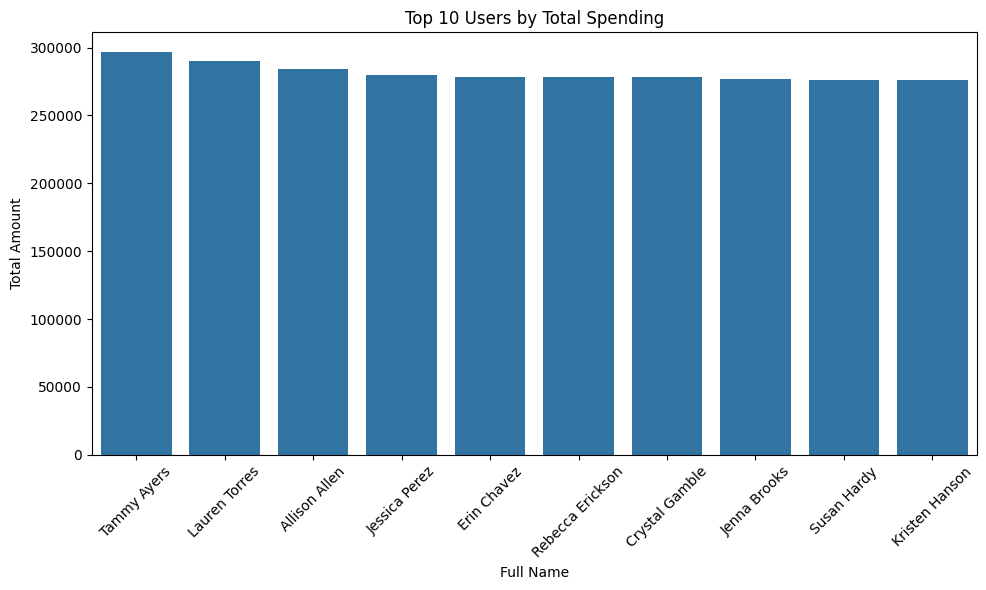

In [72]:
#Plotting top 10 users by spending
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import round, sum as _sum

user_spend_df = final_df.groupBy("cc_num").agg(round(_sum("amt"), 2).alias("total_amt"))

# Step 2: Get unique user names linked to cc_num
user_names_df = final_df.select("cc_num", "first", "last").dropDuplicates()

# Step 3: Join names to spending data
user_spend_named = user_spend_df.join(user_names_df, on="cc_num", how="left")

# Step 4: Create full name column
user_spend_named = user_spend_named.withColumn("full_name", concat_ws(" ", col("first"), col("last")))

# Step 5: Select top 10 by total_amt
top_10_named = user_spend_named.orderBy(col("total_amt").desc()).limit(10).toPandas()

# Step 6: Plot using full names
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_named, x="full_name", y="total_amt")
plt.xticks(rotation=45)
plt.title("Top 10 Users by Total Spending")
plt.xlabel("Full Name")
plt.ylabel("Total Amount")
plt.tight_layout()
plt.show()


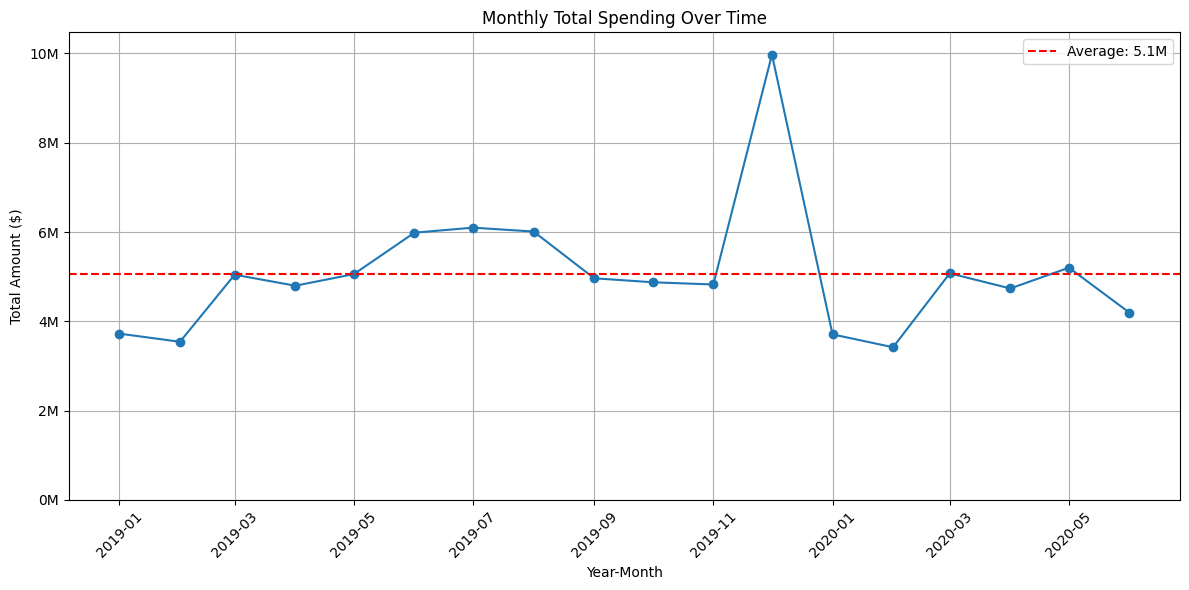

In [73]:
#Plotting time series graph of total spending over time
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
from pyspark.sql.functions import date_format, sum as _sum
from pyspark.sql.functions import col

# 1. Compute monthly totals in PySpark
monthly_df = final_df \
    .withColumn("year_month", date_format(col("trans_date_trans_time"), "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(round(_sum("amt"), 2).alias("total_amt")) \
    .orderBy("year_month")

# 2. Convert to pandas
monthly_pd = monthly_df.toPandas()
monthly_pd["year_month"] = pd.to_datetime(monthly_pd["year_month"])

# 3. Compute average
avg_amt = monthly_pd["total_amt"].mean()

# 4. Formatter for millions
def millions(x, pos):
    return f'{x * 1e-6:.0f}M'

# 5. Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_pd["year_month"], monthly_pd["total_amt"], marker='o', linestyle='-')
plt.axhline(avg_amt, color='red', linestyle='--', label=f'Average: {avg_amt/1e6:.1f}M')
plt.title("Monthly Total Spending Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Total Amount ($)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# Optional: Show 0M on Y-axis
y_min = 0
y_max = monthly_pd["total_amt"].max() * 1.05
plt.ylim(y_min, y_max)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


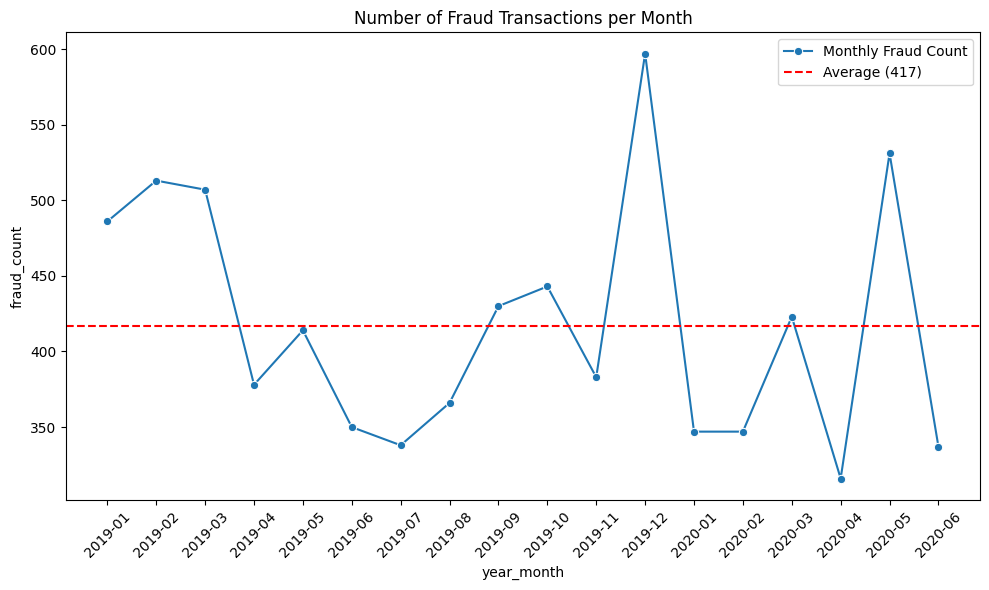

In [76]:
#Plotting time series graph of fraud transactions over time
import matplotlib.pyplot as plt
import seaborn as sns

monthly_fraud_df = final_df \
    .withColumn("year_month", date_format(col("trans_date_trans_time"), "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(_sum("is_fraud").cast("int").alias("fraud_count")) \
    .orderBy("year_month")

# Convert to pandas and sort
fraud_pd = monthly_fraud_df.toPandas().sort_values("year_month")

# Calculate the average fraud count
avg_fraud = fraud_pd["fraud_count"].mean()

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=fraud_pd,
    x="year_month",
    y="fraud_count",
    marker="o",
    label="Monthly Fraud Count"
)

# Add a horizontal average line
plt.axhline(y=avg_fraud, color='red', linestyle='--', label=f'Average ({avg_fraud:.0f})')

# Style the chart
plt.xticks(rotation=45)
plt.title("Number of Fraud Transactions per Month")
plt.legend()
plt.tight_layout()
plt.show()


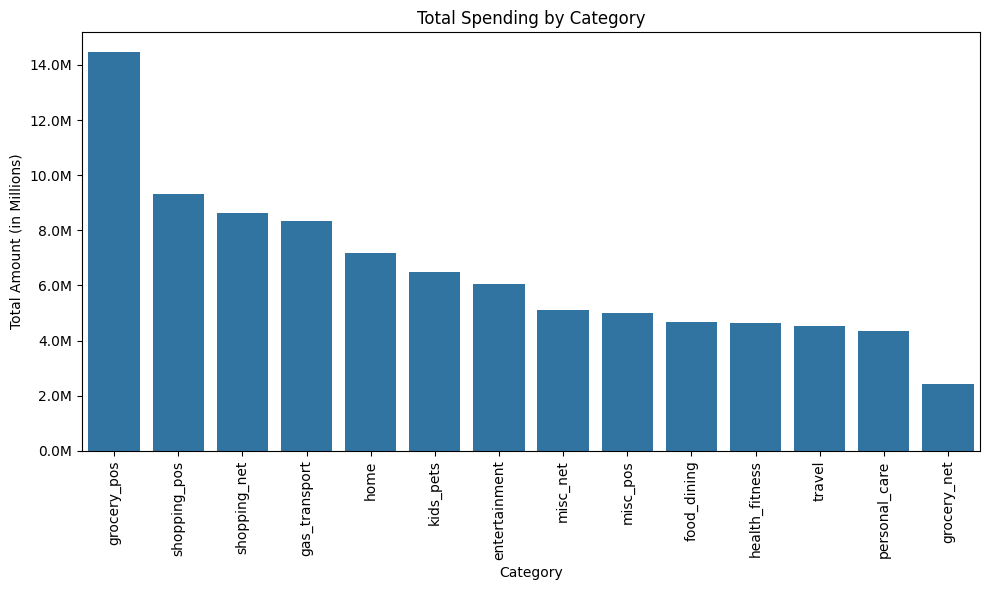

In [71]:
#Plotting total spending by category
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import sum as _sum, round, col
cat_amt_df = final_df.groupBy("category").agg(round(_sum("amt"), 2).alias("total_amt"))
cat_pd = cat_amt_df.orderBy(col("total_amt").desc()).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=cat_pd, x="category", y="total_amt")

# Format y-axis ticks in millions (e.g., 1.2M)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))

plt.xticks(rotation=90)
plt.title("Total Spending by Category")
plt.xlabel("Category")
plt.ylabel("Total Amount (in Millions)")
plt.tight_layout()
plt.show()


In [77]:
#Saving files to be loaded to Tableau
monthly_pd.to_csv("monthly_spend.csv", index=False)
fraud_pd.to_csv("monthly_fraud.csv", index=False)
top_10_named.to_csv("top_users.csv", index=False)
cat_pd.to_csv("category_spend.csv", index=False)

In [20]:
#Check columns dob if theres null or weird values.
final_df.filter((col("dob").isNull()) | (col("dob") == "")).show()

+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_eff_time|merch_last_update_time|cc_bic|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+--------------+----------------------+------+



In [23]:
import pyspark.sql.functions as F
final_df.select(F.min("dob"), F.max("dob")).show()

+----------+----------+
|  min(dob)|  max(dob)|
+----------+----------+
|1924-10-30|2005-01-29|
+----------+----------+



In [24]:
import pandas as pd

In [ ]:
#check for the 3 timestamp columns, if there are weird values.

In [25]:
final_df.select(F.min("trans_date_trans_time"), F.max("trans_date_trans_time")).show()

+--------------------------+--------------------------+
|min(trans_date_trans_time)|max(trans_date_trans_time)|
+--------------------------+--------------------------+
|       2019-01-01 00:00:18|       2020-06-21 12:13:37|
+--------------------------+--------------------------+



In [26]:
final_df.select(F.min("merch_last_update_time"), F.max("merch_last_update_time")).show()

+---------------------------+---------------------------+
|min(merch_last_update_time)|max(merch_last_update_time)|
+---------------------------+---------------------------+
|       1970-06-03 17:07:...|       2013-06-21 20:13:...|
+---------------------------+---------------------------+



In [27]:
final_df.select(F.min("merch_eff_time"), F.max("merch_eff_time")).show()

+--------------------+--------------------+
| min(merch_eff_time)| max(merch_eff_time)|
+--------------------+--------------------+
|1970-01-01 11:11:...|2013-06-21 20:13:...|
+--------------------+--------------------+



## Masking

### Method

For first and last name, combine them into full name, get the distinct one, and assign them a number, for example,

Jennifer Banks = user481 etc, then create an csv file for name mapping, so in case next time you want to know who makes this

transaction, you can get it back.

To protect the customers info, residential columns are censored with *, street, zip, lat and long.

You can either censor or drop them. Maybe dont random generate something cause it might be misleading.

In [28]:
from pyspark.sql.functions import sha2, col
mask_df = final_df.select("*")
mask_df = mask_df.withColumn("cc_num", sha2(col("cc_num").cast("string"), 256))
mask_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time,cc_bic
0,0,2019-01-01 00:00:18,80923ef01336409c8bfd3f8f5689196742e2c9871c0275...,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18.798532 +08:00,2012-01-01 08:00:18.666000 +08:00,CITIUS33CHI
1,1,2019-01-01 00:00:44,f80a8e60a9f15ecf1b85ba3370ff9c2dc0242190d8bbb7...,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159046999999994,-118.186462,0,None,2012-01-01 08:00:44.867960 +08:00,1974-03-15 07:30:04.479000 +08:00,ADMDUS41
2,2,2019-01-01 00:00:51,756a303c0348d0ebb53f6a51f114fdff35dc453af29456...,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51.506840 +08:00,2012-01-01 08:00:51.286000 +08:00,Null
3,3,2019-01-01 00:01:16,374dcb008121abf2bd02a528ddd0c6069dea0e98d65208...,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 08:01:16.794698 +08:00,2012-01-01 08:01:16.365000 +08:00,DEUTUS33TRF
4,4,2019-01-01 00:03:06,7f921c03617da992089549e1df9b9d080107bfb23d446c...,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,2012-01-01 08:03:06.746376 +08:00,1974-03-15 07:30:18.681000 +08:00,APBCUS61


In [29]:
from pyspark.sql.functions import concat_ws, col, row_number, format_string
from pyspark.sql.window import Window

# Step 1: Create full_name column
mask_df = mask_df.withColumn("full_name", concat_ws(" ", col("first"), col("last")))

# Step 2: Extract unique names for mapping (1 row per customer)
unique_names_df = mask_df.select("full_name").distinct()

# Step 3: Assign pseudonym deterministically based on insertion order
window = Window.orderBy("full_name")  # OR use monotonically_increasing_id for no shuffle

mapping_df = unique_names_df.withColumn("user_num", row_number().over(window)) \
    .withColumn("pseudonym", format_string("user_%03d", col("user_num"))) \
    .drop("user_num")

# Step 4: Join back to mask_df to assign pseudonym to each customer
mask_df = mask_df.join(mapping_df, on="full_name", how="left")

# Step 5: Replace first/last with pseudonym
mask_df = mask_df.drop("first", "last") \
       .withColumn("first", col("pseudonym")) \
       .withColumn("last", col("pseudonym")) \
       .drop("pseudonym")

# Step 6: Save mapping
mapping_df.write.mode("overwrite").csv("name_mapping.csv", header=True)


In [30]:
mask_df = mask_df.select(
    "Unnamed: 0", "trans_date_trans_time", "cc_num", "merchant", "category", "amt",
    "first", "last", "gender", "street", "city", "state", "zip", "lat", "long",
    "city_pop", "job", "dob", "trans_num", "merch_lat", "merch_long", "is_fraud",
    "merch_zipcode", "merch_eff_time", "merch_last_update_time", "cc_bic"
)

In [34]:
from pyspark.sql.functions import col, length, expr
# Step 2: Mask the columns by replacing each character with '*'
mask_df = mask_df.withColumn("street", expr("repeat('*', length(street))")) \
    .withColumn("zip", expr("repeat('*', length(zip))")) \
    .withColumn("lat", expr("repeat('*', length(cast(lat as string)))")) \
    .withColumn("long", expr("repeat('*', length(cast(long as string)))"))
mask_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time,cc_bic
0,0,2019-01-01 00:00:18,80923ef01336409c8bfd3f8f5689196742e2c9871c0275...,"fraud_Rippin, Kub and Mann",misc_net,4.97,user_418,user_418,F,**************,Moravian Falls,NC,*****,*******,********,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18.798532 +08:00,2012-01-01 08:00:18.666000 +08:00,CITIUS33CHI
1,1,2019-01-01 00:00:44,f80a8e60a9f15ecf1b85ba3370ff9c2dc0242190d8bbb7...,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,user_870,user_870,F,****************************,Orient,WA,*****,*******,*********,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159046999999994,-118.186462,0,None,2012-01-01 08:00:44.867960 +08:00,1974-03-15 07:30:04.479000 +08:00,ADMDUS41
2,2,2019-01-01 00:00:51,756a303c0348d0ebb53f6a51f114fdff35dc453af29456...,fraud_Lind-Buckridge,entertainment,220.11,user_301,user_301,M,************************,Malad City,ID,*****,*******,********,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51.506840 +08:00,2012-01-01 08:00:51.286000 +08:00,Null
3,3,2019-01-01 00:01:16,374dcb008121abf2bd02a528ddd0c6069dea0e98d65208...,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,user_437,user_437,M,***************************,Boulder,MT,*****,*******,*********,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 08:01:16.794698 +08:00,2012-01-01 08:01:16.365000 +08:00,DEUTUS33TRF
4,4,2019-01-01 00:03:06,7f921c03617da992089549e1df9b9d080107bfb23d446c...,fraud_Keeling-Crist,misc_pos,41.96,user_935,user_935,M,****************,Doe Hill,VA,*****,*******,********,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,2012-01-01 08:03:06.746376 +08:00,1974-03-15 07:30:18.681000 +08:00,APBCUS61


In [33]:
pd.set_option("display.max_columns", None)
mask_df = mask_df.orderBy("Unnamed: 0")
mask_df = mask_df.withColumn("Unnamed: 0", col("Unnamed: 0").cast("int"))
mask_df = mask_df.orderBy("Unnamed: 0")
mask_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time,cc_bic
0,0,2019-01-01 00:00:18,80923ef01336409c8bfd3f8f5689196742e2c9871c0275...,"fraud_Rippin, Kub and Mann",misc_net,4.97,user_418,user_418,F,**************,Moravian Falls,NC,*****,*******,********,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18.798532 +08:00,2012-01-01 08:00:18.666000 +08:00,CITIUS33CHI
1,1,2019-01-01 00:00:44,f80a8e60a9f15ecf1b85ba3370ff9c2dc0242190d8bbb7...,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,user_870,user_870,F,****************************,Orient,WA,*****,*******,*********,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159046999999994,-118.186462,0,None,2012-01-01 08:00:44.867960 +08:00,1974-03-15 07:30:04.479000 +08:00,ADMDUS41
2,2,2019-01-01 00:00:51,756a303c0348d0ebb53f6a51f114fdff35dc453af29456...,fraud_Lind-Buckridge,entertainment,220.11,user_301,user_301,M,************************,Malad City,ID,*****,*******,********,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51.506840 +08:00,2012-01-01 08:00:51.286000 +08:00,Null
3,3,2019-01-01 00:01:16,374dcb008121abf2bd02a528ddd0c6069dea0e98d65208...,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,user_437,user_437,M,***************************,Boulder,MT,*****,*******,*********,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 08:01:16.794698 +08:00,2012-01-01 08:01:16.365000 +08:00,DEUTUS33TRF
4,4,2019-01-01 00:03:06,7f921c03617da992089549e1df9b9d080107bfb23d446c...,fraud_Keeling-Crist,misc_pos,41.96,user_935,user_935,M,****************,Doe Hill,VA,*****,*******,********,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,2012-01-01 08:03:06.746376 +08:00,1974-03-15 07:30:18.681000 +08:00,APBCUS61


In [35]:
#Same number of rows as raw df
mask_df.count()

1296675

In [39]:
#checking for null values
from pyspark.sql.functions import col, sum

# Build a dictionary of expressions: one for each column’s null count
null_counts = mask_df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in mask_df.columns
])

In [38]:
null_counts.toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time,cc_bic
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,195973,0,0,0


In [45]:
#save  for unmasked file
final_df.coalesce(1).write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("final_df_csv")


In [80]:
#save file for masked file
mask_df.coalesce(1).write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("masked_final_df_csv")


In [46]:
#check number of frauds.
final_df.groupBy("is_fraud").count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+

